In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random

In [2]:
# Loading the walmart sales data
walmart_df = pd.read_csv("archive/walmart.csv")

In [3]:
# Displaying the first five rows
walmart_df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


### The Walmart data contains the following columns
###### Store: Identifier for the store
###### Date: The week of sale
###### Weekly_sales: Total sales for the week
###### Holiday_Flag: Whether the week has holiday or not
###### Temperature: Average temperature in the region of the store for the given week
###### Fuel_Price: Cost of fuel in the region
###### CPI: Consumer Price Index for the region
###### Unemployment: The unemployment rate in the region

In [4]:
# Checking for the missing values
walmart_df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [5]:
# Checking the data types
walmart_df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [6]:
# Converting Date column from object type to datetime format for the timeseries analysis
walmart_df['Date'] = pd.to_datetime(walmart_df['Date'], format='%d-%m-%Y')
walmart_df['Date']

0      2010-02-05
1      2010-02-12
2      2010-02-19
3      2010-02-26
4      2010-03-05
          ...    
6430   2012-09-28
6431   2012-10-05
6432   2012-10-12
6433   2012-10-19
6434   2012-10-26
Name: Date, Length: 6435, dtype: datetime64[ns]

### Now we can start doing Exploratory Data Analysis (EDA).

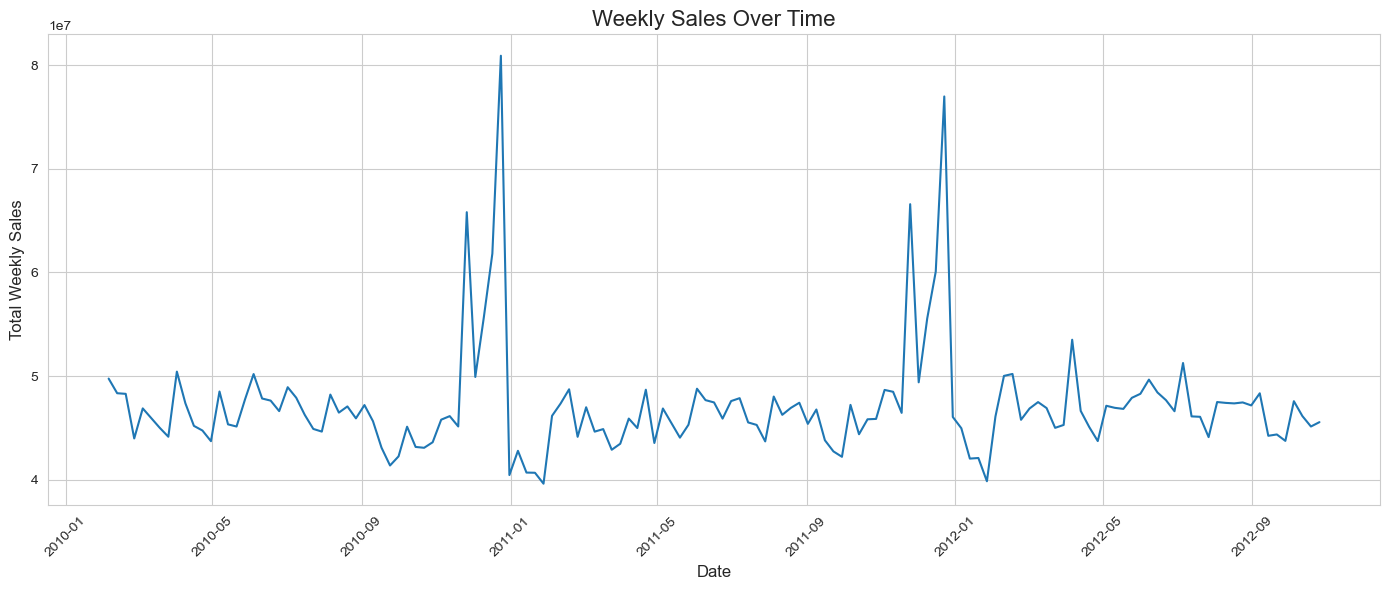

In [7]:
sns.set_style("whitegrid")

# Sales trend over time
plt.figure(figsize=(14, 6))
plt.plot(walmart_df.groupby('Date')['Weekly_Sales'].sum())
plt.title('Weekly Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Weekly Sales', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

#### In the above graph we can see noticable spikes in sales, which can be possible due to holiday periods or other seasonal events. Now we can analyse the impace of holiday on sales by comparing average sales during holiday weeks vs non-holiday weeks.

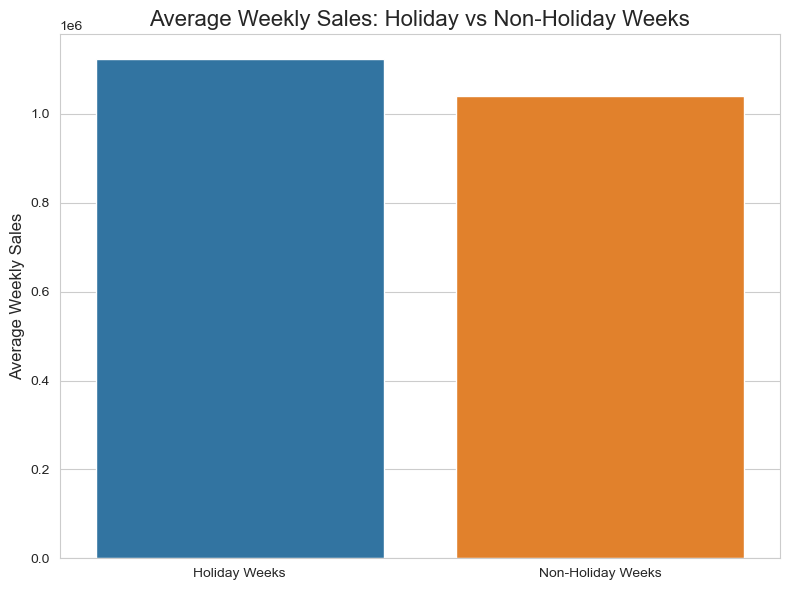

In [8]:
# Impact of Holidays on Sales
holiday_sales = walmart_df[walmart_df['Holiday_Flag'] == 1]['Weekly_Sales'].mean()
non_holiday_sales = walmart_df[walmart_df['Holiday_Flag'] == 0]['Weekly_Sales'].mean()

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x=['Holiday Weeks', 'Non-Holiday Weeks'], y=[holiday_sales, non_holiday_sales])
plt.title('Average Weekly Sales: Holiday vs Non-Holiday Weeks', fontsize=16)
plt.ylabel('Average Weekly Sales', fontsize=12)
plt.tight_layout()
plt.show()


#### In the bar chart we can see the comparison between weekly sales during holiday and non-holiday, it shows that on average during holidays weekly sales are higher than those in non-holiday weeks.

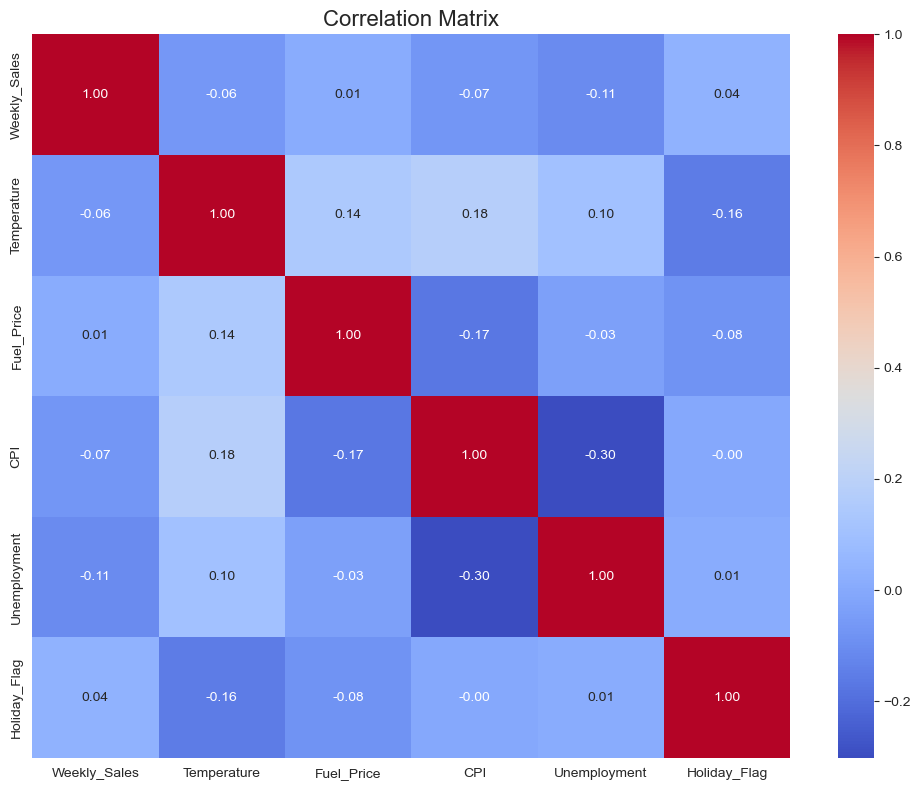

In [9]:
# Correlation Analysis
correlation_matrix = walmart_df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()


#### Temperature shows very weak coreelation with weekly sales, indicating that temperature has little to no linear relationship with sales.
#### Fuel Price also shows a weak correlation with sales, suggesting that changes in fuel prices have a minimal direct impact on weekly sales at Walmart.
#### CPI (Consumer Price Index) exhibits a weak positive correlation, indicating a slight potential relationship where sales could increase with higher CPI values, though the correlation is not strong.
#### Unemployment displays a weak negative correlation with sales, suggesting that higher unemployment rates might be associated with slightly lower sales, but again, the relationship is not strong.

### Now we'll perform Detailed Time Series Analysis and we'll also try doing Predictive modelling

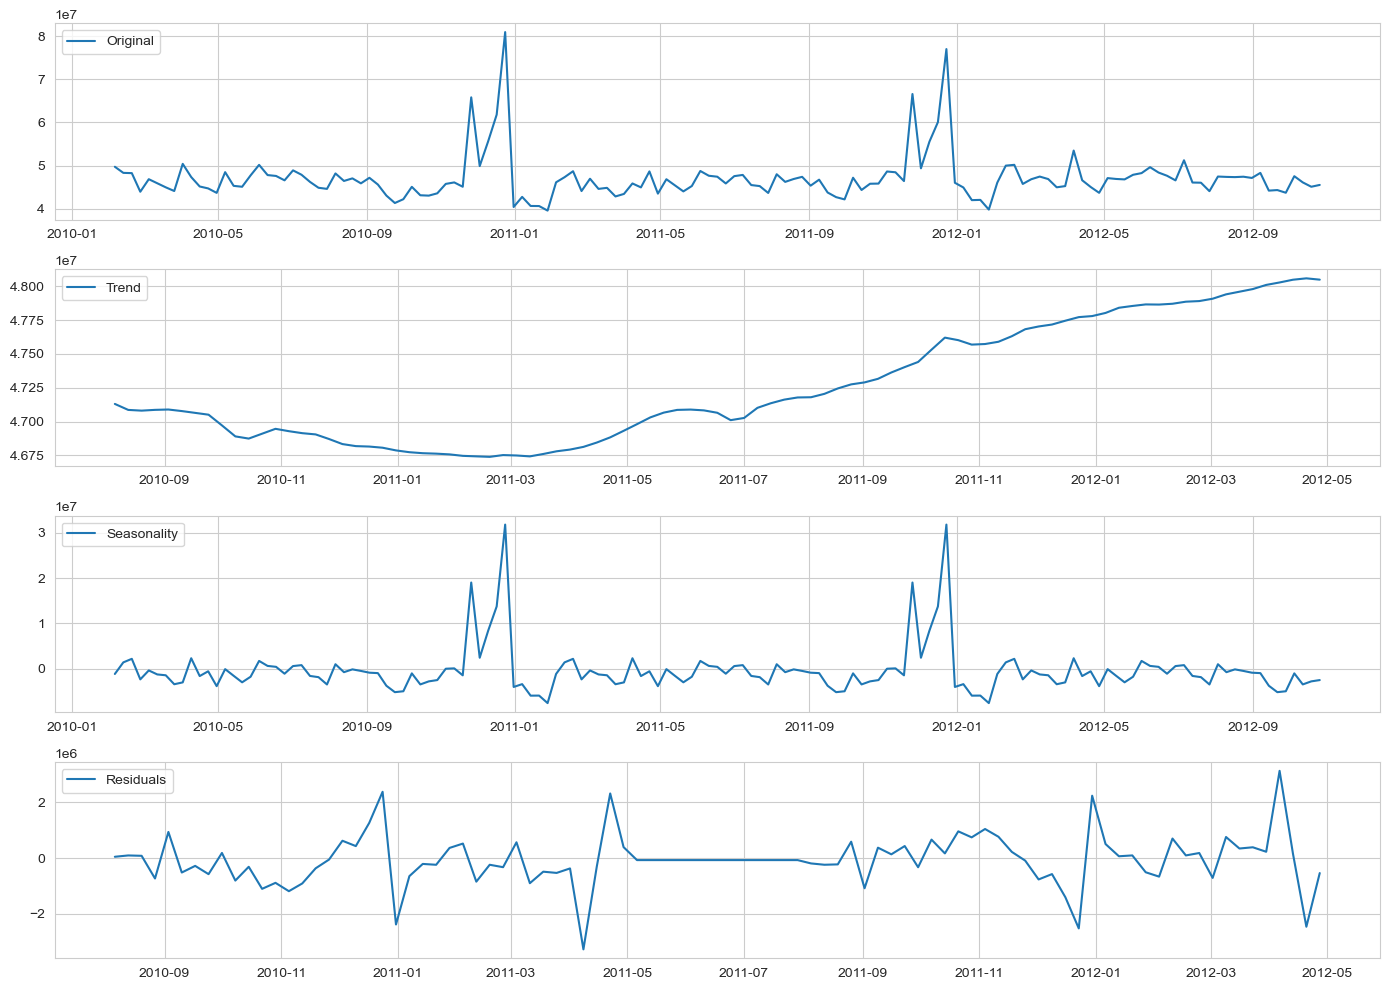

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aggregating data to get total weekly sales for all stores
weekly_sales = walmart_df.groupby('Date')['Weekly_Sales'].sum().reset_index()
weekly_sales = weekly_sales.set_index('Date')

# Seasonal decomposition to observe trends, seasonality, and residuals
decomposition = seasonal_decompose(weekly_sales, model='additive', period=52)  # Weekly data, assuming 52 weeks/year

# Plotting the decomposed components of the time series
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition.observed, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


###### Observed: This is the original time series data, which shows significant fluctuations and some apparent seasonality, especially noticeable in the spikes that likely correspond to holiday periods.

###### Trend: The trend component shows the long-term movement in the data, excluding seasonal variations and irregular fluctuations. There seems to be some variation in the trend, but no clear long-term upward or downward trend.
###### Seasonality: The seasonality component captures regular patterns that repeat over time. The plot shows clear seasonal spikes, which are consistent year over year, highlighting the impact of seasonal events or holidays on sales.
###### Residuals: These are the irregular components that remain after the trend and seasonal components have been removed. The residuals represent the noise in the data.

In [12]:
# Feature engineering: extracting week of the year and month from 'Date'
walmart_df['Week'] = walmart_df['Date'].dt.isocalendar().week
walmart_df['Month'] = walmart_df['Date'].dt.month

# Defining the features and target variable
X = walmart_df[['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Week', 'Month']]
y = walmart_df['Weekly_Sales']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Overview of the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5148, 8), (1287, 8), (5148,), (1287,))

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test_scaled)

# Evaluate the model
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)

print(f"Random Forest Test MSE: {rf_mse:.2f}, Test MAE: {rf_mae:.2f}")


Random Forest Test MSE: 13473134629.57, Test MAE: 63380.89


In [16]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [17]:
# Initialize the XGBoost Regressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)

# Fit the model to the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict on the test set
xgb_predictions = xgb_model.predict(X_test_scaled)

# Evaluate the model
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)

print(f"XGBoost Test MSE: {xgb_mse:.2f}, Test MAE: {xgb_mae:.2f}")


XGBoost Test MSE: 7687428323.81, Test MAE: 53004.53


In [18]:
param_grid = {
    'n_estimators': [100, 200, 500, 1000],  # Number of gradient boosted trees. Equivalent to number of boosting rounds.
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Boosting learning rate (xgb's "eta")
    'max_depth': [3, 4, 5, 6, 7, 8],  # Maximum tree depth for base learners.
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of the training instances.
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree.
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],  # Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization term on weights.
}

# Initialize the XGBoost Regressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

# Initialize Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

# Fit Grid Search to the data
grid_search.fit(X_train_scaled, y_train)

# Output the best parameters and scores
print("Best parameters found: ", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_

# Predict on the test set with the best model
best_xgb_predictions = best_xgb_model.predict(X_test_scaled)

# Evaluate the best model
best_xgb_mse = mean_squared_error(y_test, best_xgb_predictions)
best_xgb_mae = mean_absolute_error(y_test, best_xgb_predictions)

print(f"Best XGBoost Test MSE: {best_xgb_mse:.2f}, Test MAE: {best_xgb_mae:.2f}")


Fitting 3 folds for each of 48000 candidates, totalling 144000 fits
Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1000, 'reg_alpha': 0.1, 'subsample': 0.8}
Best XGBoost Test MSE: 6596921590.54, Test MAE: 48137.19


In [22]:
# Generate a date range for the next 2 years, monthly
future_dates = pd.date_range(start='2024-05-01', periods=24, freq='M')

# Create a DataFrame for the future dates
future_data = pd.DataFrame(future_dates, columns=['Date'])

# Extract necessary features from the date
future_data['Week'] = future_data['Date'].dt.isocalendar().week
future_data['Month'] = future_data['Date'].dt.month

# Assume placeholders for other features as before
future_data['Store'] = 1  # Assuming predictions for a specific store
future_data['Holiday_Flag'] = 0  # Assuming no holidays
future_data['Temperature'] = 60  # Placeholder average temperature
future_data['Fuel_Price'] = 3.0  # Placeholder fuel price
future_data['CPI'] = 220  # Placeholder CPI
future_data['Unemployment'] = 5.0  # Placeholder unemployment rate

# Select the columns that match the model's features
future_features = future_data[['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Week', 'Month']]

In [23]:
future_features_scaled = scaler.transform(future_features)  # Scale the future features
future_sales_predictions = best_xgb_model.predict(future_features_scaled)  # Make predictions

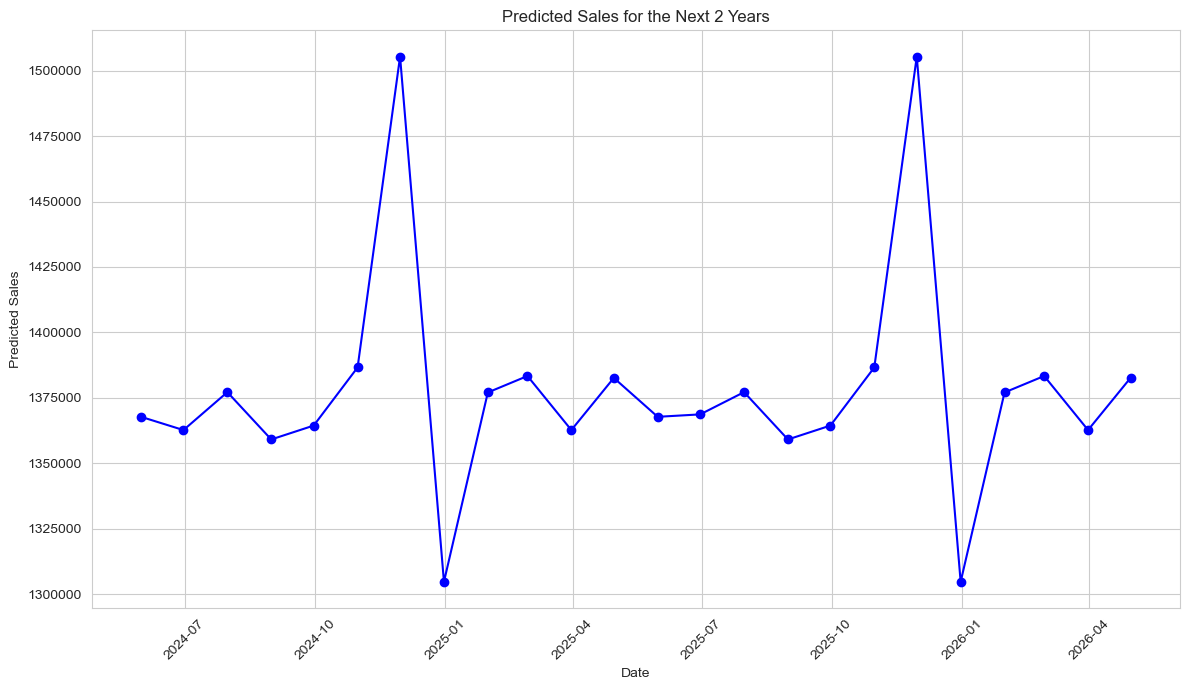

In [24]:
from matplotlib.ticker import FuncFormatter

# Function to format the y-axis as full numbers
def y_format(tick_val, pos):
    return f'{int(tick_val)}'

# Plotting the predictions
plt.figure(figsize=(12, 7))
plt.plot(future_data['Date'], future_sales_predictions, marker='o', linestyle='-', color='blue')
plt.title('Predicted Sales for the Next 2 Years')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_format))  # Apply the formatting function to y-axis
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()


In [25]:
from joblib import dump

In [30]:
model_path = 'model.joblib'

dump(best_xgb_model, model_path)

['model.joblib']

In [29]:
walmart_df.describe()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Month
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.0,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,25.818182,6.447552
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,1.0,1.000000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,14.0,4.000000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,26.0,6.000000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,38.0,9.000000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,52.0,12.000000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,14.129201,3.238308
